In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [48]:
data = pd.read_csv('data/sim_with_razor_extended.csv')
data = data.dropna()
data = data.drop('Event Number', axis=1)

In [49]:
X = data.drop('Dark Photon Produced', axis=1)
y = data['Dark Photon Produced'].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
correlation_matrix = data.corr()
correlations_with_target = correlation_matrix['Dark Photon Produced'].drop('Dark Photon Produced')
sorted_correlations = correlations_with_target.abs().sort_values(ascending=False)
sorted_correlations

MET                    0.005333
Centrality             0.004579
HT                     0.004568
Sum E_T                0.004568
Aplanarity             0.004498
Sphericity             0.004382
Invariant Mass         0.004342
MR                     0.004342
Delta R (Avg)          0.004303
Rsq                    0.003889
Event Number           0.001128
Jet Multiplicity       0.000124
Lepton Multiplicity    0.000057
Cos(Theta) Jet-MET     0.000012
Name: Dark Photon Produced, dtype: float64

In [77]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/x

In [74]:
best_params = grid_search.best_params_
print("Best hyperparameters found by GridSearchCV:", best_params)

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
final_model.fit(X_train, y_train)

#final_model.fit(X_train_resampled, y_train_resampled)

Best hyperparameters found by GridSearchCV: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}


/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [75]:
y_pred = final_model.predict(X_test)

In [76]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[99992,     3],
       [    5,     0]])

In [71]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     99995
           1       0.00      0.80      0.00         5

    accuracy                           0.93    100000
   macro avg       0.50      0.86      0.48    100000
weighted avg       1.00      0.93      0.96    100000



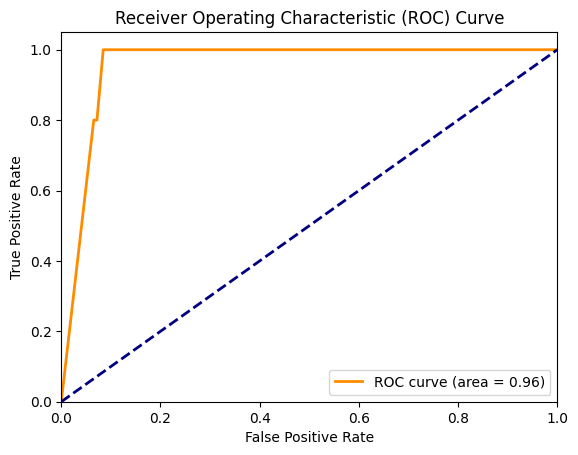

In [72]:
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()